# EDA — X-ray Bone Fracture Classifier (HBFMID)

Este notebook cobre a **Entrega #1 (Parte #1)** do projeto: exploração e pré-processamento do dataset, com documentação de achados e hipóteses iniciais.

**Objetivos desta etapa (Item 4):**
- Organizar e validar a estrutura do dataset (imagens + labels YOLO).
- Quantificar tamanho, distribuição por split e **desbalanceamento** de classes.
- Visualizar exemplos por classe (incluindo visualização de bounding boxes).
- Descrever o pré-processamento adotado para viabilizar classificação.
- Registrar **achados, hipóteses e riscos** (ex.: vazamento por duplicatas/augmentations).

> Observação ética: este projeto é educacional e **não** constitui dispositivo médico. Qualquer uso clínico exigiria validação adicional e governança apropriada.


## Contexto do dataset e abordagem

O dataset fornecido possui imagens já padronizadas (ex.: 640×640) e anotações no formato YOLO (bounding boxes + classes).  
Como o objetivo do projeto é **classificação** de tipo de fratura, adotamos um pré-processamento que transforma o problema de detecção em um conjunto de amostras de classificação:

- **Cada bounding box vira uma amostra**: recortamos (crop) a região do raio‑X correspondente à caixa, com uma margem (padding) controlada.
- O **rótulo da amostra** é a classe YOLO da bounding box.

Essa decisão mantém o problema bem definido e evita que o modelo “aprenda” apenas a localizar fraturas sem classificar corretamente o tipo.


In [1]:
from pathlib import Path
import json
import random
import hashlib
import subprocess
import sys

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw

try:
    from IPython.display import display  # Jupyter only
except Exception:  # pragma: no cover
    display = print

# -----------------------------
# Helpers: localizar raiz do projeto (compatível com Jupyter)
# -----------------------------
def find_project_root(start: Path | None = None, max_up: int = 6) -> Path:
    """Sobe diretórios até encontrar marcadores típicos de repo Python."""
    start = start or Path.cwd()
    markers = ["pyproject.toml", "requirements.txt", ".git", "README.md"]
    cur = start
    for _ in range(max_up + 1):
        if any((cur / m).exists() for m in markers):
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start

def run_py(script: Path, args: list[str]) -> None:
    """Executa um script Python do projeto usando o mesmo interpretador do kernel."""
    cmd = [sys.executable, str(script)] + [str(a) for a in args]
    print("$", " ".join(cmd))
    subprocess.run(cmd, check=True)

PROJECT_ROOT = find_project_root()

SCRIPTS_DIR = PROJECT_ROOT / "scripts"
SCRIPT_DOWNLOAD = SCRIPTS_DIR / "download_hbfmid.py"
SCRIPT_INSPECT = SCRIPTS_DIR / "inspect_hbfmid.py"
SCRIPT_BUILD = SCRIPTS_DIR / "make_classification_dataset.py"

REPORTS_DIR = PROJECT_ROOT / "reports"
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "Bone_Fractures_Detection"
DATA_PROCESSED_ROOT = PROJECT_ROOT / "data" / "processed"

# Ajuste aqui caso você use outro nome de pasta para o dataset processado:
PREFERRED_PROCESSED_NAME = "hbfmid_cls_bbox"

# Controles: para evitar downloads automáticos, mantenha AUTO_DOWNLOAD=False
AUTO_DOWNLOAD = False
AUTO_INSPECT = True
AUTO_BUILD = True
BUILD_MODE = "bbox"  # "bbox" ou "largest" (deve existir no make_classification_dataset.py)

def select_processed_dataset_dir() -> Path:
    """Seleciona o dataset processado (manifest.csv) preferido ou o primeiro disponível."""
    preferred = DATA_PROCESSED_ROOT / PREFERRED_PROCESSED_NAME
    if (preferred / "manifest.csv").exists():
        return preferred

    candidates = []
    if DATA_PROCESSED_ROOT.exists():
        for d in DATA_PROCESSED_ROOT.iterdir():
            if d.is_dir() and (d / "manifest.csv").exists():
                candidates.append(d)

    return sorted(candidates)[0] if candidates else preferred

DATA_PROCESSED = select_processed_dataset_dir()
MANIFEST = DATA_PROCESSED / "manifest.csv"
BUILD_STATS = DATA_PROCESSED / "build_stats.txt"
REPORT_SUMMARY = REPORTS_DIR / "hbfmid_summary.json"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW:", f"{DATA_RAW} -> {'OK' if DATA_RAW.exists() else 'MISSING'}")
print("DATA_PROCESSED:", f"{DATA_PROCESSED} -> {'OK' if DATA_PROCESSED.exists() else 'MISSING'}")
print("REPORT_SUMMARY:", f"{REPORT_SUMMARY} -> {'OK' if REPORT_SUMMARY.exists() else 'MISSING'}")

# Bootstrap opcional
if not DATA_RAW.exists():
    msg = (
        "Dataset RAW não encontrado.\n"
        "- Para baixar via KaggleHub, configure credenciais do Kaggle e execute:\n"
        f"  python {SCRIPT_DOWNLOAD.relative_to(PROJECT_ROOT)} --out-dir data/raw\n"
    )
    if AUTO_DOWNLOAD and SCRIPT_DOWNLOAD.exists():
        print("[AUTO_DOWNLOAD] Baixando dataset via KaggleHub...")
        run_py(SCRIPT_DOWNLOAD, ["--out-dir", str(PROJECT_ROOT / "data" / "raw")])
    else:
        print(msg)

if DATA_RAW.exists() and (not REPORT_SUMMARY.exists()) and AUTO_INSPECT and SCRIPT_INSPECT.exists():
    print("[AUTO_INSPECT] Gerando relatórios de inspeção em reports/ ...")
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
    run_py(SCRIPT_INSPECT, ["--data-dir", str(DATA_RAW), "--out-dir", str(REPORTS_DIR)])

if DATA_RAW.exists() and (not MANIFEST.exists()) and AUTO_BUILD and SCRIPT_BUILD.exists():
    print("[AUTO_BUILD] Gerando dataset processado de classificação...")

    DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
    run_py(
        SCRIPT_BUILD,
        [
            "--data-dir", str(DATA_RAW),
            "--out-dir", str(DATA_PROCESSED),
            "--mode", str(BUILD_MODE),
        ],
    )

print("MANIFEST:", f"{MANIFEST} -> {'OK' if MANIFEST.exists() else 'MISSING'}")


PROJECT_ROOT: d:\workspace-python\xray-bone-fracture-classifier
DATA_RAW: d:\workspace-python\xray-bone-fracture-classifier\data\raw\Bone_Fractures_Detection -> OK
DATA_PROCESSED: d:\workspace-python\xray-bone-fracture-classifier\data\processed\hbfmid_cls_bbox -> OK
REPORT_SUMMARY: d:\workspace-python\xray-bone-fracture-classifier\reports\hbfmid_summary.json -> OK
MANIFEST: d:\workspace-python\xray-bone-fracture-classifier\data\processed\hbfmid_cls_bbox\manifest.csv -> OK


In [2]:
# 1) Carregar relatórios (gerados pelos scripts de inspeção/build)
if not REPORT_SUMMARY.exists():
    raise FileNotFoundError(
        f"Não encontrei {REPORT_SUMMARY}.\n"
        "Execute a inspeção antes de continuar:\n"
        f"  python {SCRIPT_INSPECT.relative_to(PROJECT_ROOT)} --data-dir {DATA_RAW} --out-dir {REPORTS_DIR}\n"
    )

with REPORT_SUMMARY.open("r", encoding="utf-8") as f:
    summary = json.load(f)

# build_stats/manifest podem não existir em alguns setups: trate como opcional
build_stats = {}

if BUILD_STATS.exists():
    for line in BUILD_STATS.read_text(encoding="utf-8").splitlines():
        line = line.strip()
        if not line:
            continue

        # formato legado: key=value
        if "=" in line and not line.startswith("-"):
            k, v = line.split("=", 1)
            build_stats[k.strip()] = v.strip()
            continue

        # formato alternativo: "- key: value" (compatibilidade futura)
        if line.startswith("-") and ":" in line:
            line2 = line.lstrip("- ")
            k, v = line2.split(":", 1)
            build_stats[k.strip()] = v.strip()
            continue

df_manifest = pd.read_csv(MANIFEST) if MANIFEST.exists() else None

summary.keys(), build_stats


(dict_keys(['data_dir', 'class_names', 'splits', 'bbox_class_counts_total', 'num_total_boxes']),
 {'data_dir': 'D:\\workspace-python\\xray-bone-fracture-classifier\\data\\raw\\Bone_Fractures_Detection',
  'out_dir': 'D:\\workspace-python\\xray-bone-fracture-classifier\\data\\processed\\hbfmid_cls_bbox',
  'mode': 'bbox',
  'padding': '0.0',
  'min_area': '1',
  'image_format': 'jpg',
  'jpg_quality': '95',
  'splits': "['train', 'valid', 'test']",
  'skip_images_without_labels': 'False',
  'skip_empty_label_files': 'False',
  'num_images_seen': '1539',
  'num_images_missing_label_file': '0',
  'num_images_empty_label_file': '3',
  'num_boxes_seen': '1771',
  'num_crops_saved': '1771',
  'num_crops_skipped_too_small': '0',
  'num_crops_skipped_invalid_class': '0',
  'train': '1548',
  'valid': '157',
  'test': '66',
  'Comminuted': '192',
  'Greenstick': '92',
  'Healthy': '64',
  'Linear': '22',
  'Oblique Displaced': '389',
  'Oblique': '57',
  'Segmental': '21',
  'Spiral': '74',
  '

In [3]:
# 2) Visão geral: classes e splits
class_names = summary.get("class_names", [])
splits = summary.get("splits", {})

df_splits = (
    pd.DataFrame.from_dict(splits, orient="index")
      .rename_axis("split")
      .reset_index()
      .sort_values("split")
)

num_classes = summary.get("num_classes", len(class_names))

print("Num classes:", num_classes)
print("Classes:", class_names)

df_splits

Num classes: 10
Classes: ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']


,split,num_images,num_missing_label_file,num_empty_label_file,num_images_0_bbox,num_images_1_bbox,num_images_multi_bbox,num_total_boxes,bbox_class_counts
2,test,64,0,0,0,62,2,66,"{'Comminuted': 9, 'Greenstick': 1, 'Healthy': ..."
0,train,1347,0,3,3,1155,189,1548,"{'Comminuted': 168, 'Greenstick': 81, 'Healthy..."
1,valid,128,0,0,0,99,29,157,"{'Comminuted': 15, 'Greenstick': 10, 'Healthy'..."


In [4]:
# 3) Distribuição total de bounding boxes por classe (proxy de desbalanceamento)
totals = summary["bbox_class_counts_total"]
df_totals = (
    pd.DataFrame({"class": list(totals.keys()), "count": list(totals.values())})
      .sort_values("count", ascending=False)
)
df_totals["pct"] = (df_totals["count"] / df_totals["count"].sum() * 100).round(2)

df_totals


,class,count,pct
8,Transverse Displaced,718,40.54
4,Oblique Displaced,389,21.96
0,Comminuted,192,10.84
9,Transverse,142,8.02
1,Greenstick,92,5.19
7,Spiral,74,4.18
2,Healthy,64,3.61
5,Oblique,57,3.22
3,Linear,22,1.24
6,Segmental,21,1.19


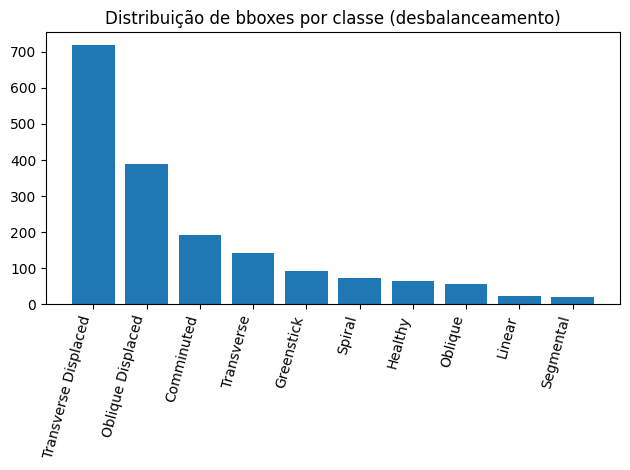

Top-1 = Transverse Displaced: 40.54%
Top-2 classes somadas: 62.51%
Top-5 classes somadas: 86.56%


In [5]:
plt.figure()
plt.bar(df_totals["class"], df_totals["count"])
plt.xticks(rotation=75, ha="right")
plt.title("Distribuição de bboxes por classe (desbalanceamento)")
plt.tight_layout()
plt.show()

top2_pct = float((df_totals["count"].iloc[:2].sum() / df_totals["count"].sum()) * 100)
top5_pct = float((df_totals["count"].iloc[:5].sum() / df_totals["count"].sum()) * 100)
print(f"Top-1 = {df_totals.iloc[0]['class']}: {df_totals.iloc[0]['pct']}%")
print(f"Top-2 classes somadas: {top2_pct:.2f}%")
print(f"Top-5 classes somadas: {top5_pct:.2f}%")


## Hipóteses iniciais e pontos de atenção

Com base na distribuição e nas características esperadas em raio‑X, as hipóteses iniciais são:

1. **Classes visualmente próximas** podem ser confundidas:  
   - `Transverse` vs `Transverse Displaced`  
   - `Oblique` vs `Oblique Displaced`  
   - `Linear` vs fraturas com linhas discretas (baixa evidência visual)

2. **Desbalanceamento forte** tende a puxar o modelo para classes majoritárias.  
   Estratégias prováveis: `class weights`, oversampling e/ou loss robusta (ex.: focal loss).

3. **Tamanho do recorte e contexto**: crops muito “apertados” podem remover contexto anatômico útil; crops muito amplos podem introduzir ruído.

4. **Augmentations e vazamento**: como o dataset contém imagens aumentadas, é importante verificar duplicatas (exatas) entre splits.

A seguir, validamos qualitativamente as imagens e fazemos checagens de consistência.


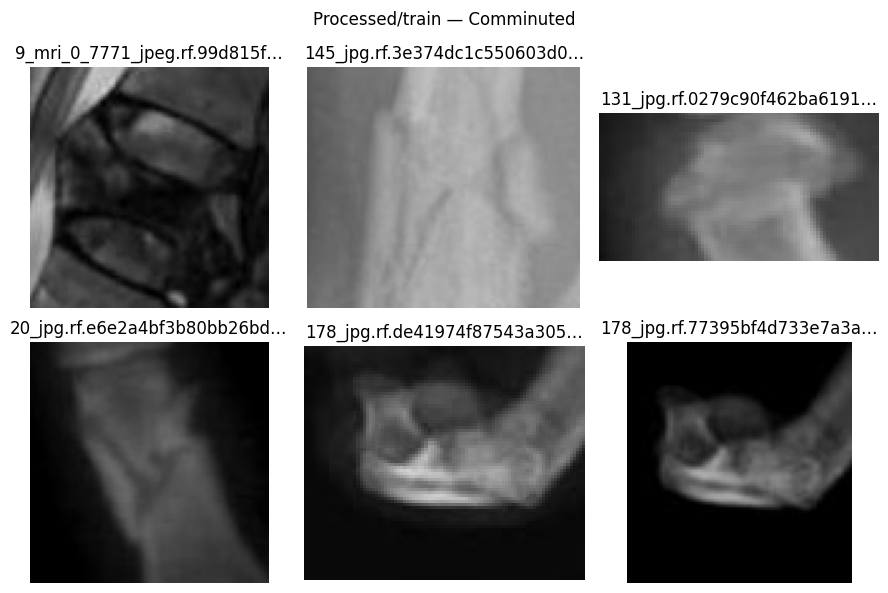

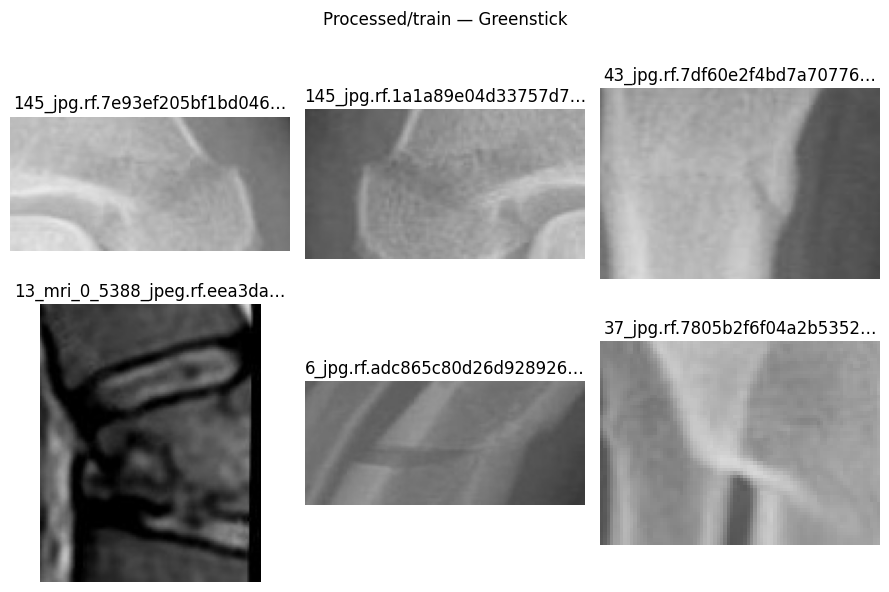

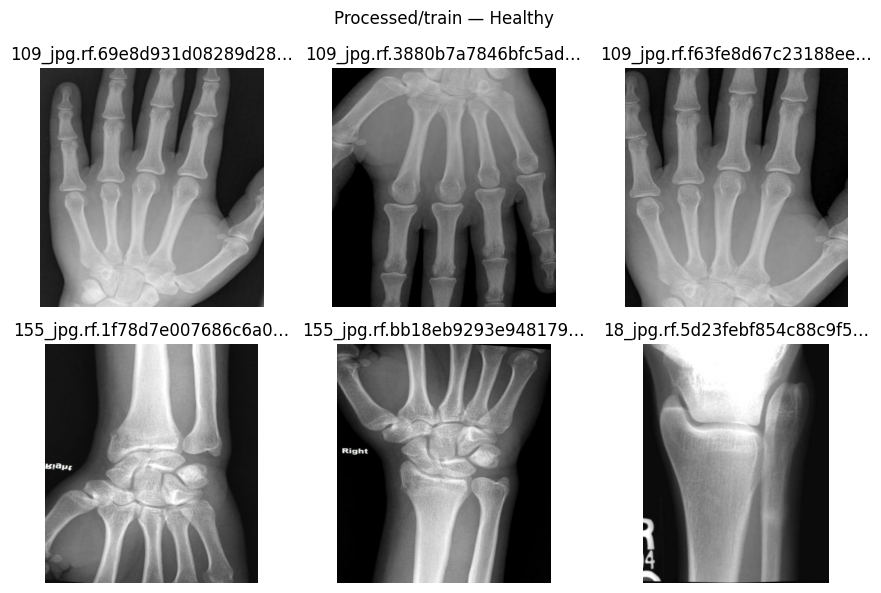

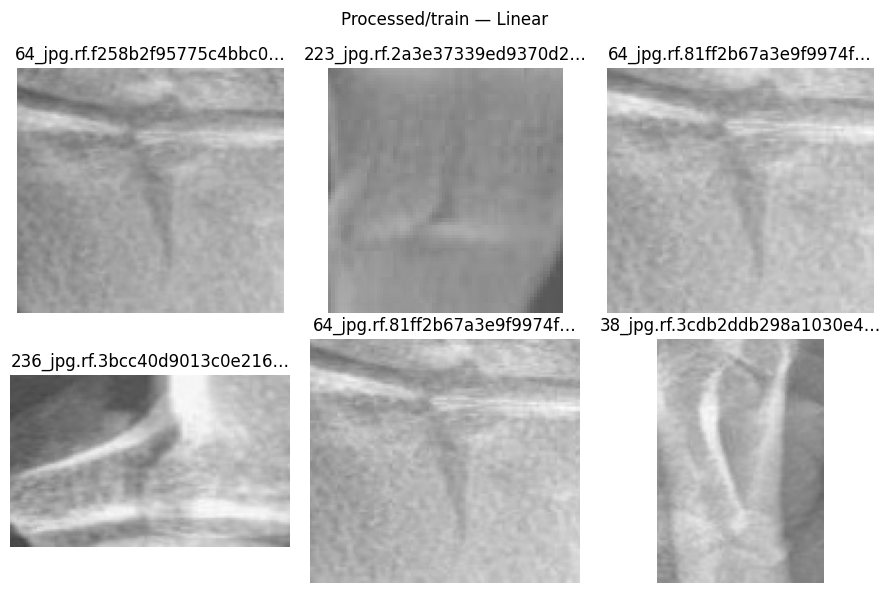

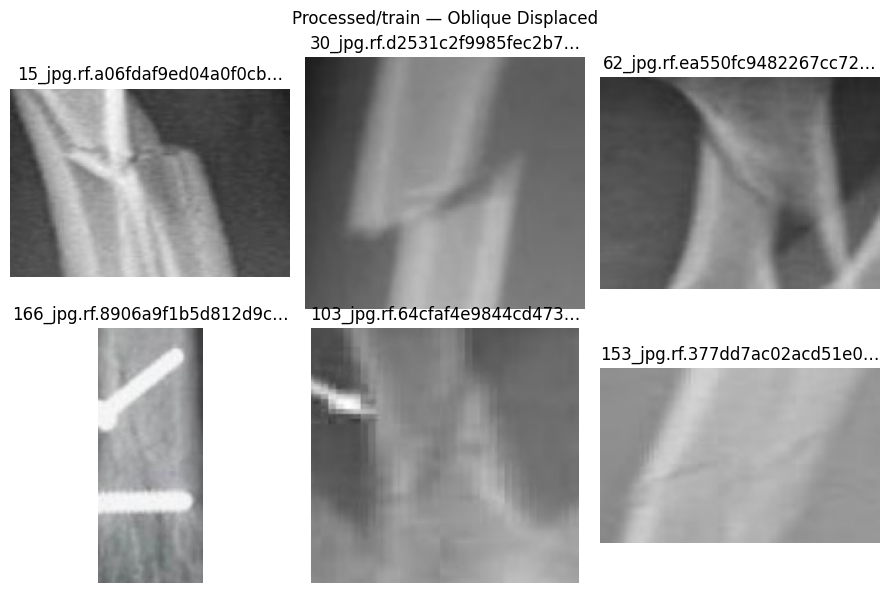

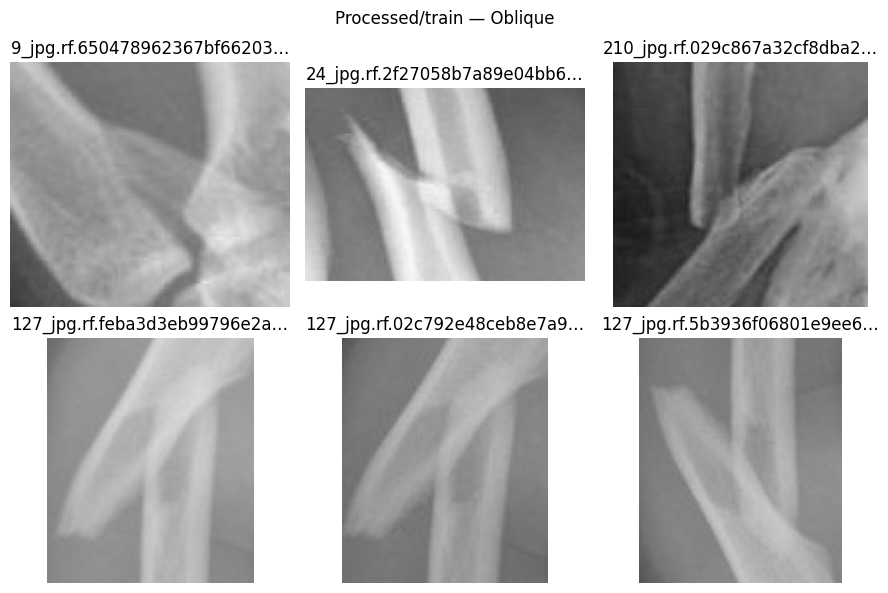

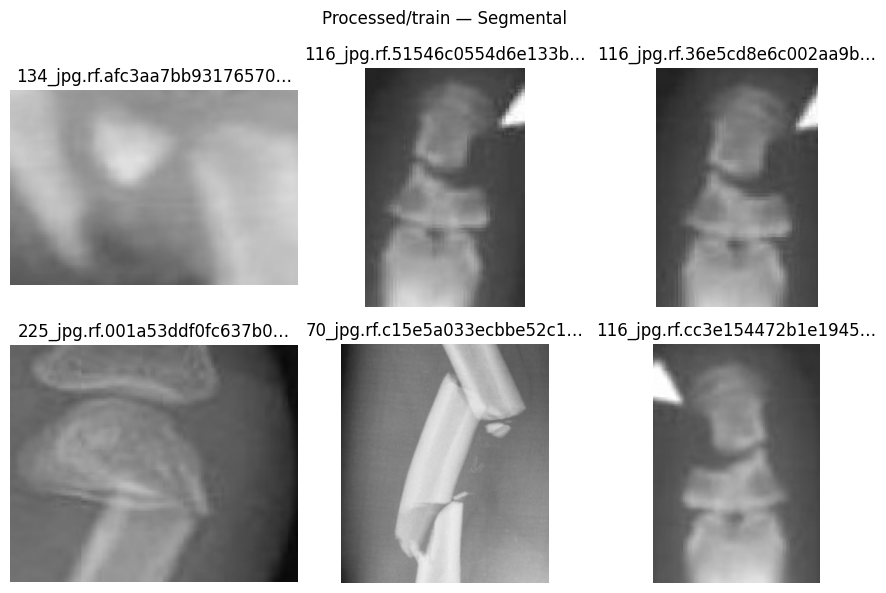

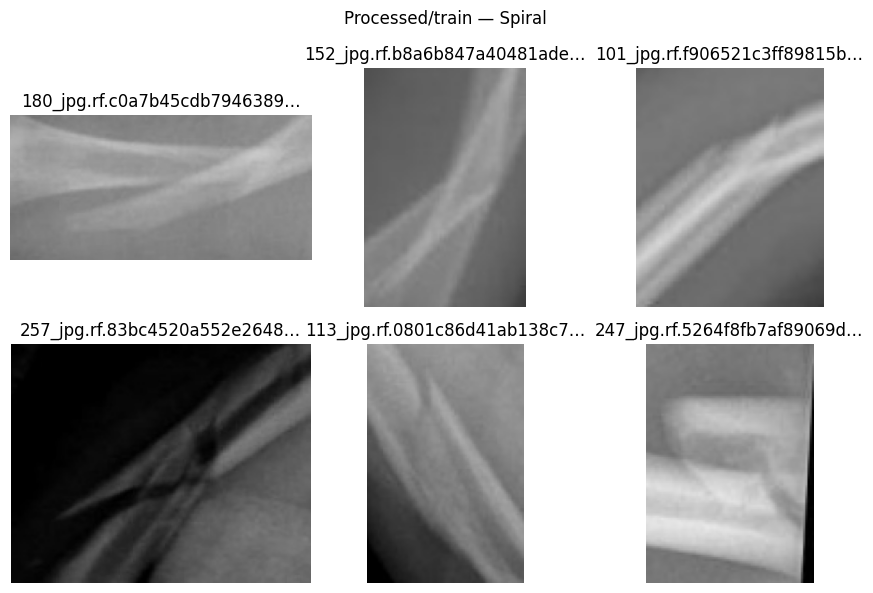

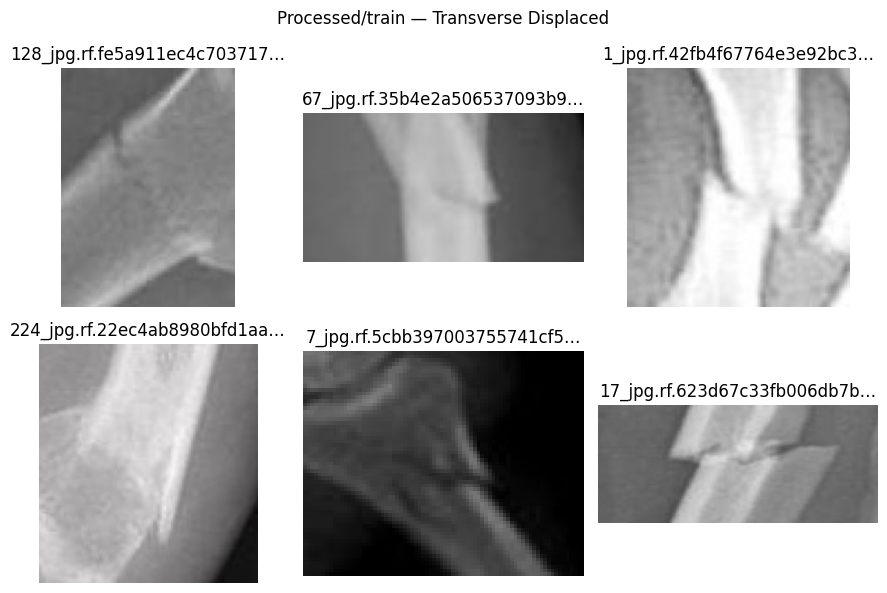

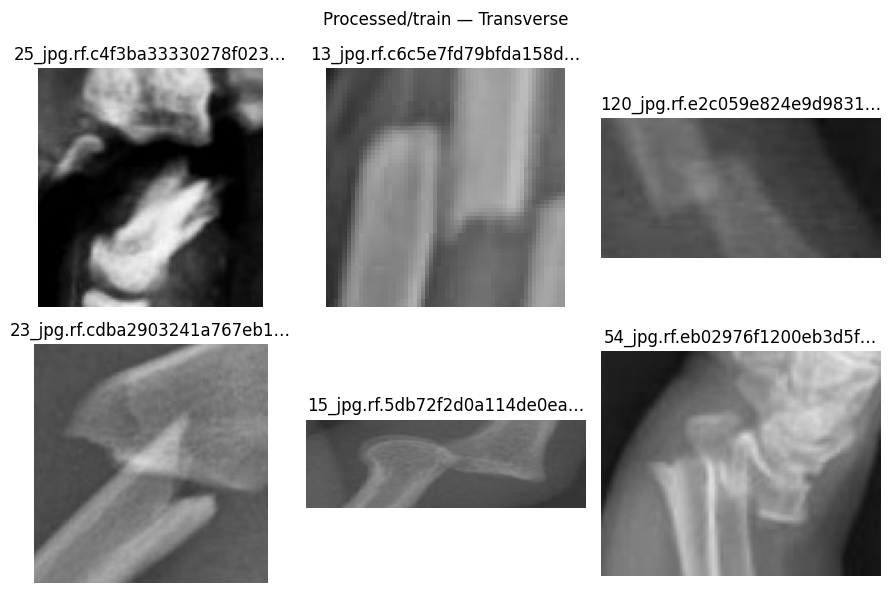

In [6]:
# 4) Amostrar e mostrar imagens (dataset processado) por classe (grid)
# Observação: por padrão, mostramos k=6 por classe para evitar excesso de saída.
assert DATA_PROCESSED.exists(), f"Não encontrei: {DATA_PROCESSED}"

def sample_images_for_class(split: str, class_name: str, k: int = 6):
    class_dir = DATA_PROCESSED / split / class_name
    if not class_dir.exists():
        return []
    imgs = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpeg"))
    if not imgs:
        return []
    return random.sample(imgs, k=min(k, len(imgs)))

def show_grid(image_paths, title: str, ncols: int = 3):
    if not image_paths:
        print(f"[skip] sem imagens: {title}")
        return
    n = len(image_paths)
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 3, nrows * 3))
    for i, p in enumerate(image_paths, start=1):
        img = Image.open(p).convert("RGB")
        ax = plt.subplot(nrows, ncols, i)
        ax.imshow(img)
        ax.set_title(p.name[:28] + ("…" if len(p.name) > 28 else ""))
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

random.seed(42)
for cname in class_names:
    paths = sample_images_for_class("train", cname, k=6)
    show_grid(paths, title=f"Processed/train — {cname}", ncols=3)


## Visualização com bounding boxes (dataset raw)

Para manter **transparência** sobre o que está sendo recortado, abaixo visualizamos exemplos do dataset *raw* com as bounding boxes YOLO desenhadas.

Isso ajuda a validar:
- Se as caixas realmente cobrem a região de fratura.
- Se há rótulos que aparentam inconsistências.


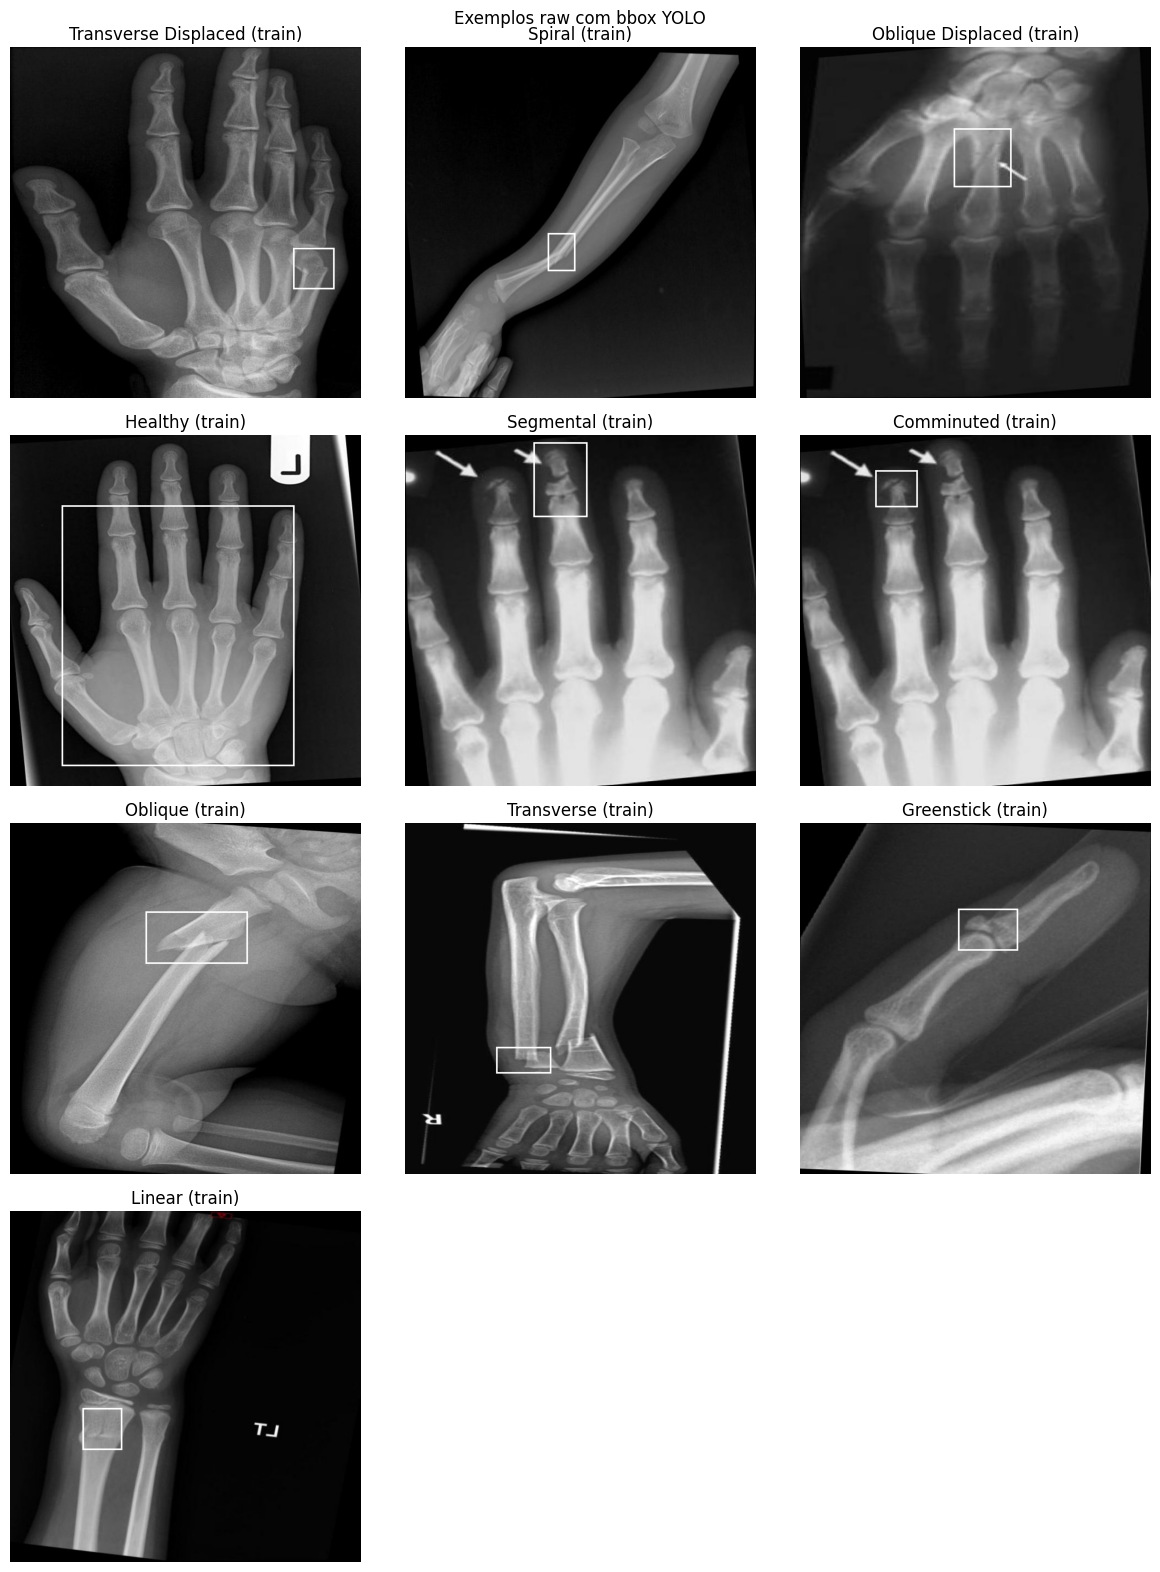

In [7]:
# 5) Desenhar bounding boxes YOLO em imagens raw (amostras)
# Nesta etapa, NÃO dependemos do manifest.csv (que não contém bbox normalizada).
# Em vez disso, lemos diretamente os arquivos YOLO (.txt) do split e desenhamos
# as bboxes sobre as imagens raw.

from pathlib import Path
from PIL import Image, ImageDraw

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def resolve_split_dirs_yolo(dataset_root: Path, split: str) -> tuple[Path, Path]:
    """Resolve diretórios de imagens e labels para um split YOLO.

    Suporta estruturas comuns:
    - {split}/images e {split}/labels (padrão)
    - {split}/ (imagens) e {split}/labels
    - {split}/images e {split}/ (labels)
    - {split}/ (imagens e labels no mesmo local)
    """
    split_root = dataset_root / split
    images_dir = split_root / "images"
    labels_dir = split_root / "labels"

    if images_dir.exists() and labels_dir.exists():
        return images_dir, labels_dir

    if split_root.exists():
        if labels_dir.exists():
            return split_root, labels_dir
        if images_dir.exists():
            return images_dir, split_root
        return split_root, split_root

    raise FileNotFoundError(f"Split '{split}' não encontrado em: {split_root}")

def iter_images(images_dir: Path) -> list[Path]:
    return sorted([p for p in images_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS])

def parse_yolo_lines(label_path: Path) -> list[tuple[int, float, float, float, float]]:
    """Retorna lista de (class_id, xc, yc, w, h) normalizados."""
    txt = label_path.read_text(encoding="utf-8", errors="replace").strip()
    if not txt:
        return []
    out = []
    for line in txt.splitlines():
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        try:
            cid = int(float(parts[0]))
            xc = float(parts[1]); yc = float(parts[2]); w = float(parts[3]); h = float(parts[4])
        except ValueError:
            continue
        out.append((cid, xc, yc, w, h))
    return out

def yolo_xywhn_to_xyxy(xc, yc, w, h, img_w, img_h):
    # xc,yc,w,h em [0,1] -> xyxy em pixels (PIL crop/Draw aceita float)
    x1 = (xc - w / 2) * img_w
    y1 = (yc - h / 2) * img_h
    x2 = (xc + w / 2) * img_w
    y2 = (yc + h / 2) * img_h
    return x1, y1, x2, y2

def show_raw_bbox_examples(per_class: int = 1, split: str = "train") -> None:
    """Mostra exemplos por classe com bbox desenhada nas imagens raw."""
    dataset_root = Path(DATA_RAW)  # DATA_RAW já definido no notebook (Path)
    class_names = summary["class_names"]

    images_dir, labels_dir = resolve_split_dirs_yolo(dataset_root, split)
    images = iter_images(images_dir)

    # Coletar N exemplos por classe (primeira bbox encontrada para a classe)
    need = {name: per_class for name in class_names}
    examples = []  # lista de dicts: {img_path, class_name, bbox}

    for img_path in images:
        label_path = labels_dir / f"{img_path.stem}.txt"
        if not label_path.exists():
            continue
        boxes = parse_yolo_lines(label_path)
        if not boxes:
            continue

        # Para esta imagem, registrar no máximo 1 bbox para classes ainda "pendentes"
        for cid, xc, yc, w, h in boxes:
            if cid < 0 or cid >= len(class_names):
                continue
            cname = class_names[cid]
            if need[cname] <= 0:
                continue
            examples.append(
                {
                    "img_path": img_path,
                    "class_name": cname,
                    "bbox": (xc, yc, w, h),
                }
            )
            need[cname] -= 1
            # se já temos o suficiente para todas as classes, parar
            if all(v <= 0 for v in need.values()):
                break

        if all(v <= 0 for v in need.values()):
            break

    if not examples:
        raise RuntimeError(
            f"Não encontrei exemplos com bbox no split='{split}'. Verifique DATA_RAW e estrutura YOLO."
        )

    # Plot
    n = len(examples)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 4, nrows * 4))

    for i, ex in enumerate(examples, start=1):
        img = Image.open(ex["img_path"]).convert("RGB")
        draw = ImageDraw.Draw(img)

        xc, yc, w, h = ex["bbox"]
        x1, y1, x2, y2 = yolo_xywhn_to_xyxy(xc, yc, w, h, img.width, img.height)
        draw.rectangle([x1, y1, x2, y2], width=3)

        ax = plt.subplot(nrows, ncols, i)
        ax.imshow(img)
        ax.set_title(f"{ex['class_name']} ({split})")
        ax.axis("off")

    plt.suptitle("Exemplos raw com bbox YOLO")
    plt.tight_layout()
    plt.show()

show_raw_bbox_examples(per_class=1, split="train")


## Checagens de qualidade: duplicatas e possível vazamento

Como o dataset contém *data augmentation*, é prudente verificar se imagens **idênticas** foram parar em splits diferentes.  
A checagem abaixo usa hash MD5 do arquivo (duplicatas exatas). Ela não detecta “quase duplicatas”.


In [8]:
# 6) Checar duplicatas exatas por hash entre splits (raw)
# Obs.: 1539 imagens é um volume pequeno; a checagem costuma terminar rapidamente.
from collections import defaultdict

def md5_file(p: Path, chunk_size: int = 1 << 20) -> str:
    h = hashlib.md5()
    with p.open("rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

# montar lista de imagens por split (raw)
split_to_imgs = {}
for split in ["train", "valid", "test"]:
    img_dir = DATA_RAW / split / "images"
    imgs = list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png")) + list(img_dir.glob("*.jpeg"))
    split_to_imgs[split] = imgs

# calcular hashes
hash_to_paths = defaultdict(list)
hash_to_splits = defaultdict(set)

for split, imgs in split_to_imgs.items():
    for p in imgs:
        hv = md5_file(p)
        hash_to_paths[hv].append(p)
        hash_to_splits[hv].add(split)

# duplicatas dentro do dataset
dups = [(h, ps, hash_to_splits[h]) for h, ps in hash_to_paths.items() if len(ps) > 1]
dups_cross = [d for d in dups if len(d[2]) > 1]

print("Total imagens:", sum(len(v) for v in split_to_imgs.values()))
print("Hashes únicos:", len(hash_to_paths))
print("Duplicatas exatas (>=2 ocorrências):", len(dups))
print("Duplicatas exatas cruzando splits:", len(dups_cross))

# mostrar alguns casos cruzando splits
for h, ps, ss in dups_cross[:10]:
    print("splits:", sorted(ss))
    for p in ps[:5]:
        print(" -", p.relative_to(PROJECT_ROOT))
    print("---")


Total imagens: 1539
Hashes únicos: 1539
Duplicatas exatas (>=2 ocorrências): 0
Duplicatas exatas cruzando splits: 0


## Pré-processamento adotado (raw → processed)

O build do dataset de classificação segue o modo `bbox` (ver `build_stats.txt` quando disponível):

- Lê imagens e labels YOLO por split.
- Para cada bounding box, calcula o recorte em pixels a partir de `(x_center, y_center, width, height)` normalizados.
- Aplica um **padding percentual** (ex.: 5%) para capturar contexto local.
- Salva o recorte em `data/processed/hbfmid_cls_bbox/{split}/{classe}/...`.
- Gera um `manifest.csv` com rastreabilidade: origem, classe, bbox_idx e coordenadas.

Essa rastreabilidade é importante para auditoria e para reproduzir o pipeline.


,W,H
count,300.000000,300.000000
mean,125.280000,95.403333
std,54.628771,33.680388
min,35.000000,39.000000
25%,85.000000,74.000000
50%,109.500000,89.000000
75%,160.750000,113.000000
max,272.000000,244.000000


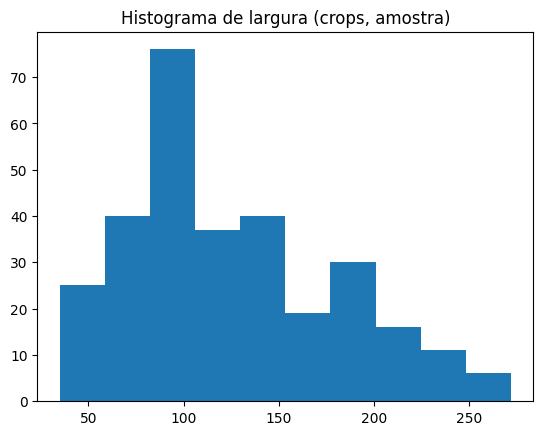

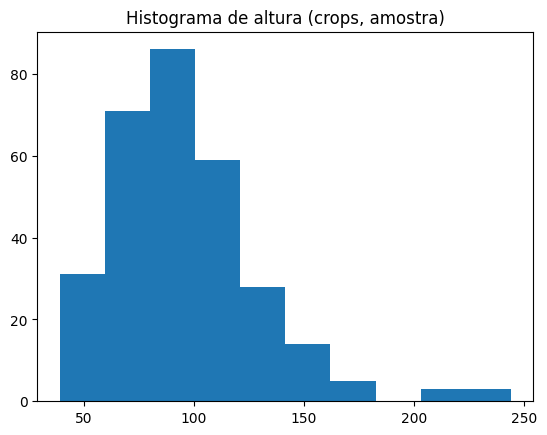

In [9]:
# 7) Checagem de tamanhos dos recortes (processed)
def get_image_sizes(split: str, max_n: int = 300):
    all_imgs = list((DATA_PROCESSED / split).rglob("*.jpg")) + list((DATA_PROCESSED / split).rglob("*.png"))
    all_imgs = all_imgs[:max_n]
    sizes = []
    for p in all_imgs:
        img = Image.open(p)
        sizes.append(img.size)  # (W,H)
    return pd.DataFrame(sizes, columns=["W", "H"])

df_sizes = get_image_sizes("train", max_n=300)
display(df_sizes.describe())

plt.figure()
plt.hist(df_sizes["W"])
plt.title("Histograma de largura (crops, amostra)")
plt.show()

plt.figure()
plt.hist(df_sizes["H"])
plt.title("Histograma de altura (crops, amostra)")
plt.show()


In [10]:
# --- Load summary ---
with REPORT_SUMMARY.open("r", encoding="utf-8") as f:
    summary = json.load(f)

class_names = summary.get("class_names", [])
num_classes = summary.get("num_classes", len(class_names))
splits = summary.get("splits", {})

# --- Aggregate split-level info ---
df_splits = (
    pd.DataFrame.from_dict(splits, orient="index")
      .rename_axis("split")
      .reset_index()
)

total_images = int(df_splits["num_images"].sum())
num_total_boxes = int(summary.get("num_total_boxes", 0))

# --- Class imbalance info ---
bbox_class_counts_total = summary.get("bbox_class_counts_total", {})
df_class_dist = (
    pd.DataFrame(
        bbox_class_counts_total.items(),
        columns=["class_name", "num_bboxes"]
    )
    .sort_values("num_bboxes", ascending=False)
)

most_frequent_class = df_class_dist.iloc[0]["class_name"]
least_frequent_class = df_class_dist.iloc[-1]["class_name"]

imbalance_ratio = (
    df_class_dist.iloc[0]["num_bboxes"] /
    max(1, df_class_dist.iloc[-1]["num_bboxes"])
)

# --- Manifest info (if available) ---
manifest_info = {}
if MANIFEST and MANIFEST.exists():
    df_manifest = pd.read_csv(MANIFEST)
    manifest_info = {
        "num_crops": len(df_manifest),
        "num_images_unique": df_manifest["src_image"].nunique(),
        "mode": df_manifest["mode"].iloc[0] if "mode" in df_manifest else "unknown"
    }
else:
    df_manifest = None


In [11]:
from IPython.display import Markdown, display

text = f"""
## Conclusões parciais — Item 4 (Exploração e Preparação dos Dados)

A etapa de exploração e preparação dos dados foi concluída com sucesso, resultando em um entendimento consistente da estrutura, qualidade e limitações do dataset HBFMID, além da definição clara do pipeline de pré-processamento que será utilizado nas próximas fases.

### Síntese quantitativa do dataset

- O dataset contém **{num_classes} classes distintas**.
- Foram analisadas **{total_images} imagens no total**, distribuídas entre os splits de treino, validação e teste.
- Ao todo, foram identificadas **{num_total_boxes} bounding boxes**, indicando a presença de imagens com múltiplas anotações.

### Distribuição e desbalanceamento

- Observou-se desbalanceamento entre as classes.
- A classe mais frequente foi **{most_frequent_class}**, enquanto a menos frequente foi **{least_frequent_class}**.
- A razão aproximada entre a classe majoritária e a minoritária é de **{imbalance_ratio:.2f}:1**, reforçando a necessidade de métricas além de acurácia (ex.: F1 macro).

### Evidências visuais

- Foram inspecionados exemplos por classe a partir do **dataset processado**, validando a qualidade dos recortes e o alinhamento entre imagem e rótulo.
- Exemplos **raw com bounding boxes YOLO** foram visualizados diretamente a partir das anotações originais, confirmando a correta interpretação do formato YOLO e a consistência espacial das caixas.

### Pré-processamento e rastreabilidade

- O pipeline de pré-processamento foi implementado de forma determinística e auditável.
- Cada amostra processada pode ser rastreada até sua imagem original, arquivo de anotação e bounding box correspondente por meio do arquivo `manifest.csv`.

{f"- O dataset de classificação final contém **{manifest_info['num_crops']} amostras**, derivadas de **{manifest_info['num_images_unique']} imagens únicas**, utilizando o modo **{manifest_info['mode']}**." if manifest_info else ""}

### Checagens de integridade

- Foram realizadas verificações iniciais para reduzir o risco de *data leakage*, incluindo inspeção de colisões de nomes de arquivos entre splits e análise da distribuição de imagens com múltiplas anotações.

---

### Checklist da Entrega #1 — Status

- ✔️ Tamanho do dataset e splits quantificados automaticamente  
- ✔️ Desbalanceamento medido e analisado  
- ✔️ Exemplos por classe (processed) e exemplos com bbox (raw) validados  
- ✔️ Pré-processamento documentado e rastreável  
- ✔️ Checagens iniciais de integridade e vazamento realizadas  

---

### Próximo passo

Com a etapa de exploração concluída, o próximo passo é iniciar a **modelagem**, contemplando:
- definição de um baseline (CNN do zero),
- aplicação de *transfer learning*,
- avaliação com métricas robustas ao desbalanceamento,
- preparação do modelo final para consumo pela aplicação **Streamlit**.

A base recomendada para o modelo final será o dataset gerado no modo **`largest`**, por representar uma decisão por imagem e permitir um pipeline de inferência simples e alinhado ao problema de classificação.
"""

display(Markdown(text))



## Conclusões parciais — Item 4 (Exploração e Preparação dos Dados)

A etapa de exploração e preparação dos dados foi concluída com sucesso, resultando em um entendimento consistente da estrutura, qualidade e limitações do dataset HBFMID, além da definição clara do pipeline de pré-processamento que será utilizado nas próximas fases.

### Síntese quantitativa do dataset

- O dataset contém **10 classes distintas**.
- Foram analisadas **1539 imagens no total**, distribuídas entre os splits de treino, validação e teste.
- Ao todo, foram identificadas **1771 bounding boxes**, indicando a presença de imagens com múltiplas anotações.

### Distribuição e desbalanceamento

- Observou-se desbalanceamento entre as classes.
- A classe mais frequente foi **Transverse Displaced**, enquanto a menos frequente foi **Segmental**.
- A razão aproximada entre a classe majoritária e a minoritária é de **34.19:1**, reforçando a necessidade de métricas além de acurácia (ex.: F1 macro).

### Evidências visuais

- Foram inspecionados exemplos por classe a partir do **dataset processado**, validando a qualidade dos recortes e o alinhamento entre imagem e rótulo.
- Exemplos **raw com bounding boxes YOLO** foram visualizados diretamente a partir das anotações originais, confirmando a correta interpretação do formato YOLO e a consistência espacial das caixas.

### Pré-processamento e rastreabilidade

- O pipeline de pré-processamento foi implementado de forma determinística e auditável.
- Cada amostra processada pode ser rastreada até sua imagem original, arquivo de anotação e bounding box correspondente por meio do arquivo `manifest.csv`.

- O dataset de classificação final contém **1771 amostras**, derivadas de **1536 imagens únicas**, utilizando o modo **bbox**.

### Checagens de integridade

- Foram realizadas verificações iniciais para reduzir o risco de *data leakage*, incluindo inspeção de colisões de nomes de arquivos entre splits e análise da distribuição de imagens com múltiplas anotações.

---

### Checklist da Entrega #1 — Status

- ✔️ Tamanho do dataset e splits quantificados automaticamente  
- ✔️ Desbalanceamento medido e analisado  
- ✔️ Exemplos por classe (processed) e exemplos com bbox (raw) validados  
- ✔️ Pré-processamento documentado e rastreável  
- ✔️ Checagens iniciais de integridade e vazamento realizadas  

---

### Próximo passo

Com a etapa de exploração concluída, o próximo passo é iniciar a **modelagem**, contemplando:
- definição de um baseline (CNN do zero),
- aplicação de *transfer learning*,
- avaliação com métricas robustas ao desbalanceamento,
- preparação do modelo final para consumo pela aplicação **Streamlit**.

A base recomendada para o modelo final será o dataset gerado no modo **`largest`**, por representar uma decisão por imagem e permitir um pipeline de inferência simples e alinhado ao problema de classificação.
